In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [3]:
train_set = torchvision.datasets.CIFAR10('./datasets', train=True, 
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False, 
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, 
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, 
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


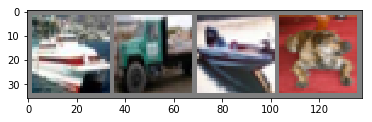

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:4]))

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cuda:0


In [7]:
class LeNet(nn.Module):
    
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(True),
            nn.Linear(120, 84),
            nn.ReLU(True),
            nn.Linear(84, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.classifier(x)
        return x

In [8]:
net = LeNet().to(device)
print(net)

Net(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [9]:
learning_rate = 1e-3
momentum = 0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

In [10]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')

[1,  2000] loss: 2.200
[1,  4000] loss: 4.062
[1,  6000] loss: 5.725
[1,  8000] loss: 7.295
[1, 10000] loss: 8.812
[1, 12000] loss: 10.266
[2,  2000] loss: 1.373
[2,  4000] loss: 2.728
[2,  6000] loss: 4.054
[2,  8000] loss: 5.368
[2, 10000] loss: 6.659
[2, 12000] loss: 7.946
Finished Training


GroundTruth:    cat  ship  ship plane


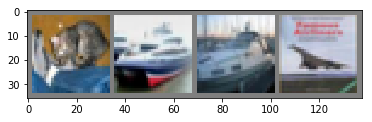

In [11]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs.cpu(), 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 76 %
Accuracy of   car : 46 %
Accuracy of  bird : 40 %
Accuracy of   cat : 26 %
Accuracy of  deer : 38 %
Accuracy of   dog : 50 %
Accuracy of  frog : 65 %
Accuracy of horse : 60 %
Accuracy of  ship : 71 %
Accuracy of truck : 68 %
